In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import torch
import torch.nn as nn
import os
import time

from random import shuffle
from scipy.stats import gamma, beta, nbinom, poisson
from scipy.special import gammaln, betaln
from torch.autograd import Variable
import sys 
sys.path.append('../')
from utils import *

%matplotlib inline

mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['figure.figsize'] = (15, 5)

## Generate Poisson data, compare Poisson vs. negBin model

I will train a MDN to approximate the posterior over model indices. As models I use a Poisson with Gamma prior and a negative Binomial with Beta prior. To this end I will generate a large data set of samples from either Poisson or NB with hyperparameters sampled from the priors. This data set I will use to train the MDN. Finally I will generate test data from either Poisson or NB with hyperparameters chosen as the mean of the corresponding prior. Given the test data the analytical Bayes factor and the Bayes factor predicted by the model is compared. 

### Controlling difficulty via over / under dispersion 
Overdispersion means that the dispersion predicted by the model is less than that present in the data. Here we can control the difficulty of distinguishing between the two models by changing the dispersion of the observed data and by making use of the fact that while in the Poisson model the mean equals the variance, in the NB model we have an additional DoF for the variance. 

Given that we want to start with a very simple case, we should choose the Gamma and Beta priors on the Poisson and the NB model such that they result in very different data models. 

In [2]:
sample_size = 100
n_samples = 500000
seed = 2

figure_folder = '../figures/'

difficult = False
diff_string = 'diff' if difficult else 'easy'

time_stamp = time.strftime('%Y%m%d%H%M_')

# set prior parameters 
# gamma prior shape and scale x
shape = 9. if difficult else 7.5
scale = 0.5 if difficult else 1.0 
# create a frozen distribution object
gamma_prior = gamma(a=shape, scale=scale)

# beta prior shape and scale 
alp = 2. if difficult else 5.0 
bet = 5. if difficult else 2.0 
# neg bin number of successes, fixed
r = 3.
beta_prior = beta(a=alp, b=bet)

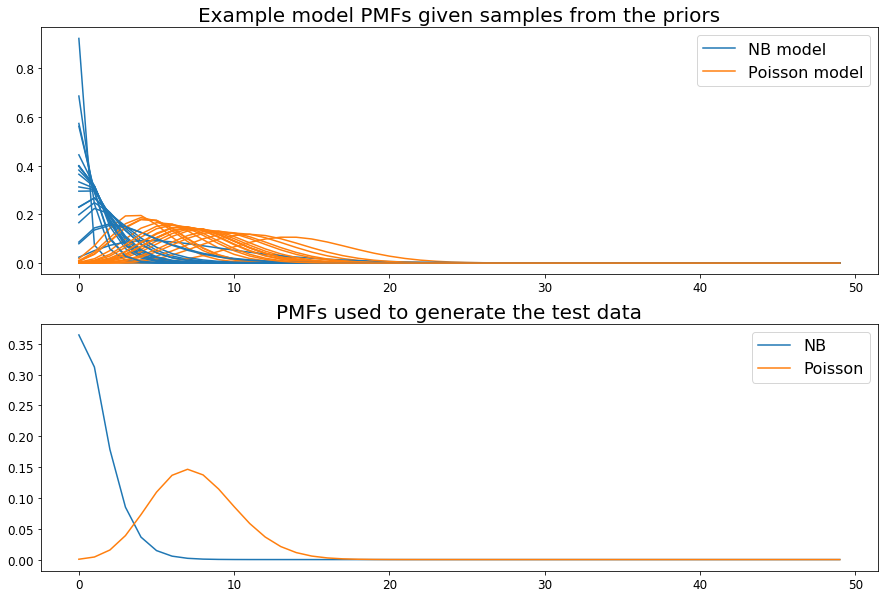

In [3]:
k = np.arange(50)

plt.figure(figsize=(15, 10))
plt.subplot(211)
for i in range(20): 
    priorNB = nbinom.pmf(k, r, beta_prior.rvs())
    priorP = poisson.pmf(k, gamma_prior.rvs())
    
    plt.plot(k, priorNB, 'C0')
    plt.plot(k, priorP, 'C1')
    
plt.title('Example model PMFs given samples from the priors')
plt.legend(['NB model', 'Poisson model'])

plt.subplot(212)
plt.plot(k, nbinom.pmf(k, r, beta_prior.mean()), 'C0')
plt.plot(k, poisson.pmf(k, gamma_prior.mean()), 'C1')
plt.title('PMFs used to generate the test data')
plt.legend(['NB', 'Poisson'])

save_figure(filename='data_pmfs_' + diff_string, time_stamp=time_stamp, folder=figure_folder)

## Define functions for generating data from the two different models

In [4]:
def calculate_stats(x):
    return np.array([np.sum(x).astype(float)])

def generate_dataset(n_samples, sample_size): 
    
    X = []
    thetas = []
    m = []

    # for every sample we want a triplet (m_i, theta, sx)
    for i in range(n_samples): 
        
        # sample model index 
        m_i = np.round(np.random.rand()).astype(int)
    
        # generate data from model 
        if m_i == 0: 
            theta, x = generate_poisson(sample_size, gamma_prior)
        elif m_i == 1: 
            theta, x = generate_negbin(sample_size, r, beta_prior)
            
        sx = calculate_stats(x)
            
        X.append(sx)
        thetas.append([theta])
        m.append([int(m_i)])
    
    return m, np.array(thetas), np.array(X)

## Define network for fitting the model posterior

In [5]:
class MDN_psi(nn.Module):
    
    def __init__(self, ndim_input=1, ndim_output=2, n_hidden=5, n_components=1):
        super(MDN_psi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.m_out = nn.Linear(n_hidden, ndim_output)

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_m = self.m_out(act)
        return out_m
    
def train_psi(X, Y, model, optim, lossfun, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]
    
    losses = []

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))            
            y_var = Variable(torch.LongTensor(y_batch)).view(n_minibatch)
            
            (out_act) = model(x_var)
            loss = lossfun(out_act, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            losses.append(loss.data[0])

        if (epoch + 1) % 100 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim, losses

## Generate a large data set of triplets (m, theta, sx)

Then separate it into sets for model 1 and model 2 and train the phi networks separately. 

In [6]:
# generate data 
m, theta, X = generate_dataset(n_samples, sample_size)

# normalize 
X, norm = normalize(X)

In [7]:
n_inputs = 1
model = MDN_psi(ndim_input=n_inputs, n_hidden=10)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lossfun = nn.CrossEntropyLoss()

model_psi, optim_psi, losses = train_psi(X, m, model, optim, lossfun, n_epochs=200, n_minibatch=1000)

[epoch 0100] loss: 0.1766
[epoch 0200] loss: 0.1869


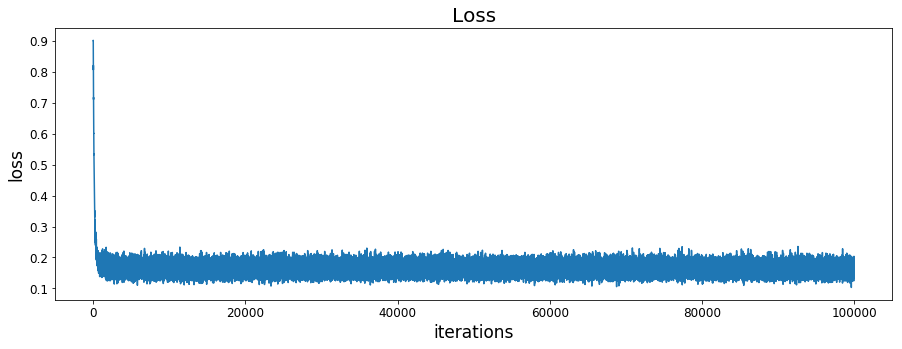

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss');

## Draw many samples and compare predicted to analytical Bayes Factor

In [9]:
bf_true = []
bf_predicted = []
model_indices = []
pred_mi = []
prob_poisson = []
ppoi_ana = []

# gather summary stats
stats = []

# set the parameters of the underlying model as the means of the corresponding priors
poi_mean = gamma_prior.mean()
nb_psuccess = beta_prior.mean()

# flag for plotting sample distributions
plot = False

softmax = nn.Softmax(dim=1)

Ntest = 50

np.random.seed(seed)
for i in range(Ntest): 
    
    # sample model index 
    m_i = np.round(np.random.rand()).astype(int)
    
    # draw samples from the model given by the model index 
    if m_i == 0: 
        samples = poisson.rvs(mu=gamma_prior.rvs(), size=sample_size)
    elif m_i == 1: 
        samples = nbinom.rvs(n=r, p=beta_prior.rvs(), size=sample_size)
            
    if plot: 
        plt.subplot(1, 2, m_i + 1)
        plt.title('NB' if m_i else 'Poisson')
        plt.hist(samples, bins='auto', alpha=.5)
    
    # apply model for prediction
    stats_o = np.array(calculate_stats(samples)).reshape(1, n_inputs)
    stats_o, norm = normalize(stats_o, norm)
        
    stats.append(stats_o)
    
    X_var = Variable(torch.Tensor(stats_o))
    (out_act) = model(X_var)
    
    # in this vector, index 0 is Poi, index 1 is NB
    posterior_probs = softmax(out_act).data.numpy()[0]
    prob_poisson.append(posterior_probs[0])
    
    # predict the model with the larger posterior 
    pred_mi.append(np.argmax(posterior_probs))
    
    # because we use a uniform prior the posterior ratio corresponds to the likelihood (evidence) ratio
    e0 = poisson_evidence(samples, shape, scale, log=True)
    e1 = nbinom_evidence(samples, r, alp, bet, log=True)

    # calculate bf
    log_bftrue = e0 - e1
    log_bfpred = np.log(posterior_probs[0] / posterior_probs[1])
    ppoi_ana.append(calculate_pprob_from_evidences(np.exp(e0), np.exp(e1)))
    
    # append to lists
    bf_predicted.append(log_bfpred)
    bf_true.append(log_bftrue)
    model_indices.append(m_i)
    
# true indices 
mi_true = np.array(model_indices)

# MAP estimate of model index 
mi_pred = (np.array(bf_predicted) < 0)  # np.array(pred_mi)

# predict m_i = 1 if log BF negaive, m_i = 0 if it is positive
mi_ana = (np.array(bf_true) < 0)

stats = np.array(stats).reshape(Ntest, n_inputs)
bf_true = np.array(bf_true)
bf_predicted = np.array(bf_predicted)

## Visualize the input output function of the network: p(model=Poisson) = f(sum(x))

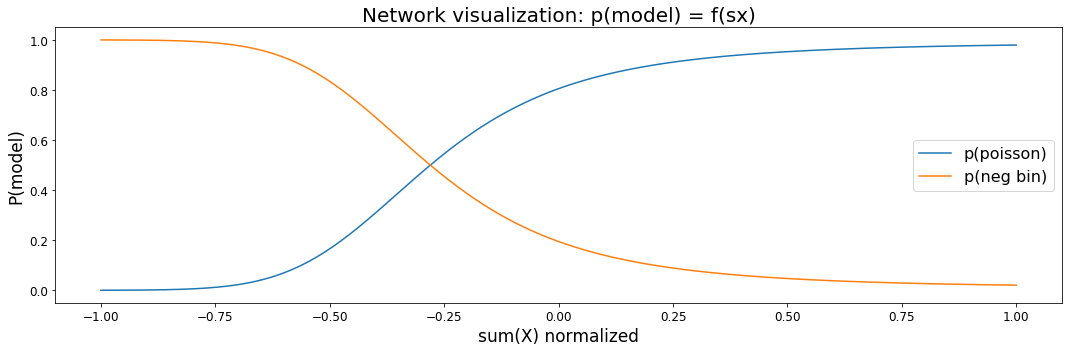

In [10]:
stats_range = np.linspace(-1., 1., 1000)
probs = []
for st in stats_range: 
    (out_act) = model(Variable(torch.Tensor([[st]])))
        
    # in this vector, index 0 is Poi, index 1 is NB
    probs.append(softmax(out_act).data.numpy()[0][0])
        
plt.plot(stats_range, np.array(probs), label='p(poisson)')
plt.plot(stats_range, 1 - np.array(probs), label='p(neg bin)')
plt.ylabel('P(model)')
plt.xlabel('sum(X) normalized')
plt.title('Network visualization: p(model) = f(sx)')
plt.legend();

plt.tight_layout()
save_figure(filename='network_visualization_{}'.format(diff_string), folder=figure_folder, time_stamp=time_stamp)

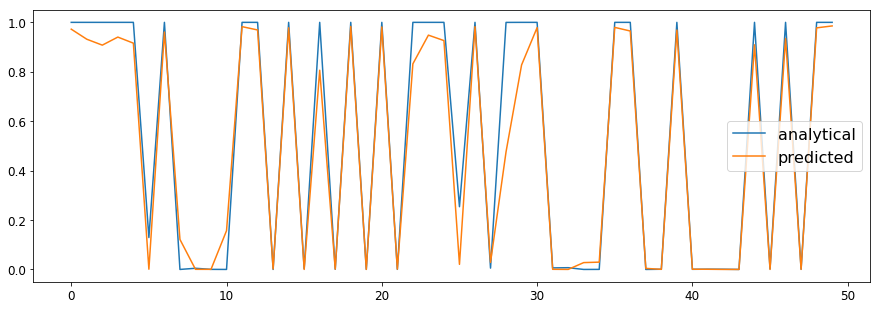

In [11]:
plt.plot(ppoi_ana, label='analytical')
plt.plot(prob_poisson, label='predicted')
plt.legend();

## Plotting summary stats 

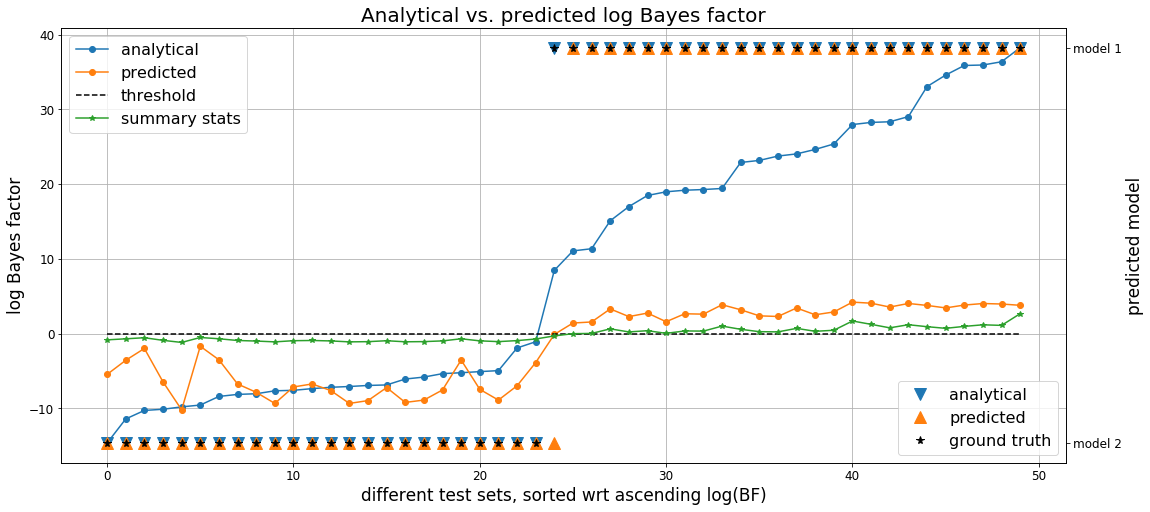

In [12]:
# sort the array to ascending BF 
sort_idx = np.argsort(bf_true).astype(int)
ss = stats.squeeze()[sort_idx]


plt.figure(figsize=(18, 8))
plt.plot(bf_true[sort_idx], '-o', label='analytical')
plt.ylabel('log Bayes factor, analytical')

#plt.twinx()
plt.plot(bf_predicted[sort_idx], 'o-', label='predicted')
plt.ylabel('log Bayes factor')
plt.xlabel('different test sets, sorted wrt ascending log(BF)')
plt.title('Analytical vs. predicted log Bayes factor')
plt.plot(np.zeros(Ntest), '--', label='threshold', color='k')
plt.plot(ss, '*-', label='summary stats')
plt.legend(loc='best')
plt.grid()
#plt.ylim([-2, 2])

plt.twinx()
plt.yticks([0, 1], ['model 2', 'model 1'])

plt.plot(mi_ana[sort_idx]==0, 'v', markersize=12, label='analytical')
plt.plot(mi_pred[sort_idx]==0, '^', markersize=12, label='predicted')
plt.plot(mi_true[sort_idx]==0, '*', markersize=8, label='ground truth', color='k')
plt.legend(loc=4)
plt.ylabel('predicted model')

save_figure(filename='bf_evaluation_N{}M{}_{}'.format(n_samples, sample_size, diff_string), folder=figure_folder, 
            time_stamp=time_stamp)

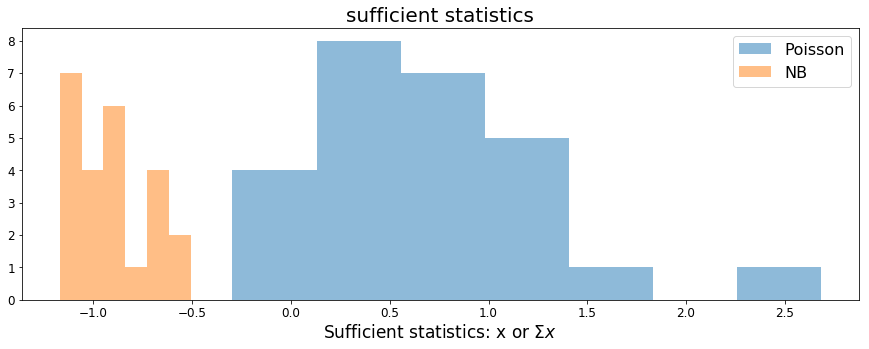

In [13]:
plt.title('sufficient statistics')
plt.hist(stats[mi_true.astype(int)==0, 0], bins='auto', label='Poisson', alpha=.5)
plt.hist(stats[mi_true.astype(int)==1, 0], bins='auto', label='NB', alpha=.5)
plt.xlabel(r'Sufficient statistics: x or $\Sigma x$')
plt.legend();
save_figure(filename='stats_hists_' + diff_string, folder=figure_folder, time_stamp=time_stamp)

## Calculating ROC 

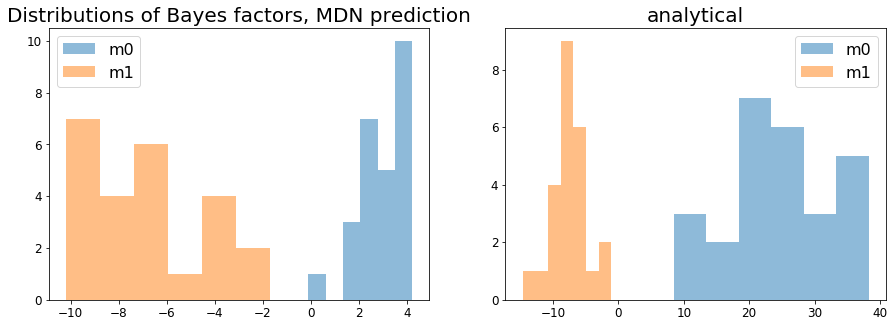

In [14]:
bf_predicted = np.array(bf_predicted)
bf_true = np.array(bf_true)
#plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.title('Distributions of Bayes factors, MDN prediction')
plt.hist(bf_predicted[mi_true.astype(int)==0], bins='auto', alpha=0.5, label='m0')
plt.hist(bf_predicted[mi_true.astype(int)==1], bins='auto', alpha=0.5, label='m1');
plt.legend()
plt.subplot(122)
plt.title('analytical')
plt.hist(bf_true[mi_true.astype(int)==0], bins='auto', alpha=0.5, label='m0')
plt.hist(bf_true[mi_true.astype(int)==1], bins='auto', alpha=0.5, label='m1')
plt.legend()
save_figure(filename='bf_distributions.png', folder=figure_folder, time_stamp=time_stamp);

In [15]:
thresholds = np.linspace(-30, 30, 1000)
tpr_mdn = []
fpr_mdn = []
tpr_ana = []
fpr_ana = []

m0_mask = mi_true.astype(int)==0
m1_mask = mi_true.astype(int)==1

def get_rate(th, arr): 
    count = (arr >= th).sum()
    rate = count / arr.size
    
    return rate

for th in thresholds: 
    
    # tpr is the integral of the m0 distribution 
    tpr_mdn.append(get_rate(th, bf_predicted[m0_mask]))
    tpr_ana.append(get_rate(th, bf_true[m0_mask]))
    
    # fpr is the integral of the m1 distribution 
    fpr_mdn.append(get_rate(th, bf_predicted[m1_mask]))
    fpr_ana.append(get_rate(th, bf_true[m1_mask]))

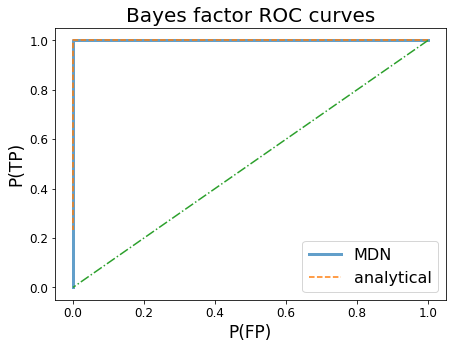

In [16]:
plt.figure(figsize=(7, 5))
plt.title('Bayes factor ROC curves')
plt.ylabel('P(TP)')
plt.xlabel('P(FP)')
plt.plot(fpr_mdn, tpr_mdn, lw=3., alpha=.7, label='MDN')
plt.plot(fpr_ana, tpr_ana, '--', label='analytical')
plt.plot(fpr_ana, fpr_ana, '-.')
plt.legend()
save_figure(filename='bf_roc_' + diff_string, folder=figure_folder, time_stamp=time_stamp)

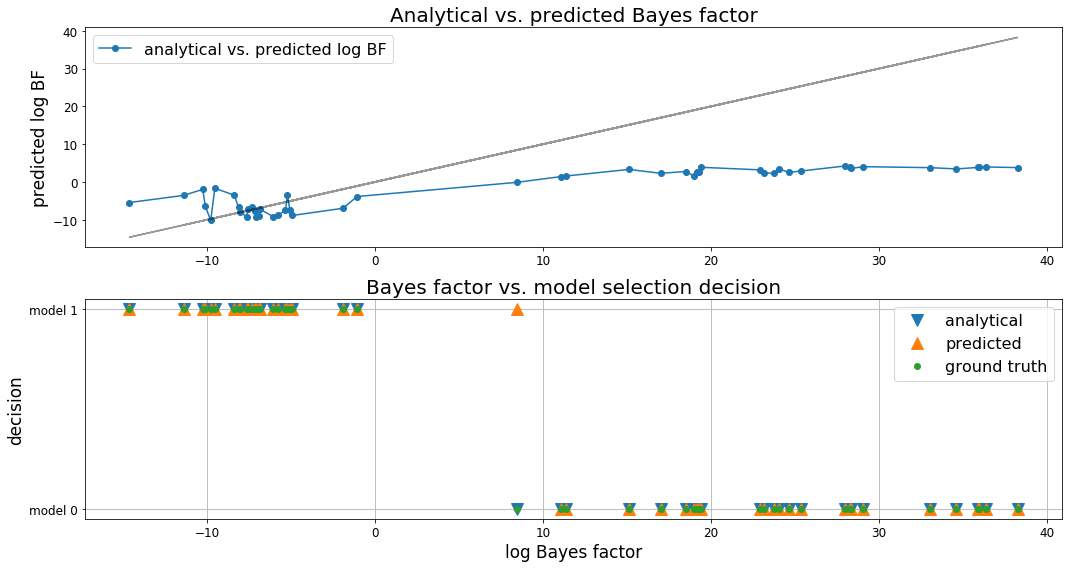

In [17]:
plt.figure(figsize=(15, 8))
plt.subplot(211)
plt.plot(bf_true[sort_idx], bf_predicted[sort_idx], 'o-', label='analytical vs. predicted log BF')
plt.plot(bf_true, bf_true, color='k', alpha=0.4)
plt.ylabel('predicted log BF')
#plt.xlabel('analytical BF')
#plt.grid()
plt.title('Analytical vs. predicted Bayes factor')
plt.legend()

plt.subplot(212)
plt.yticks([0, 1], ['model 0', 'model 1'])
plt.plot(bf_true[sort_idx], mi_ana[sort_idx], 'v', markersize=12, label='analytical')
plt.plot(bf_true[sort_idx], mi_pred[sort_idx], '^', markersize=12, label='predicted')
plt.plot(bf_true[sort_idx], mi_true[sort_idx], 'o', markersize=6, label='ground truth')
plt.xlabel('log Bayes factor')
plt.ylabel('decision')
plt.title('Bayes factor vs. model selection decision')
#plt.ylim([-.5, 1.2])
plt.grid()
plt.legend();
plt.tight_layout()

save_figure(filename='bf_decison_comparison', folder=figure_folder, time_stamp=time_stamp)

In [18]:
np.corrcoef(bf_true, bf_predicted)

array([[ 1.        ,  0.90195394],
       [ 0.90195394,  1.        ]])

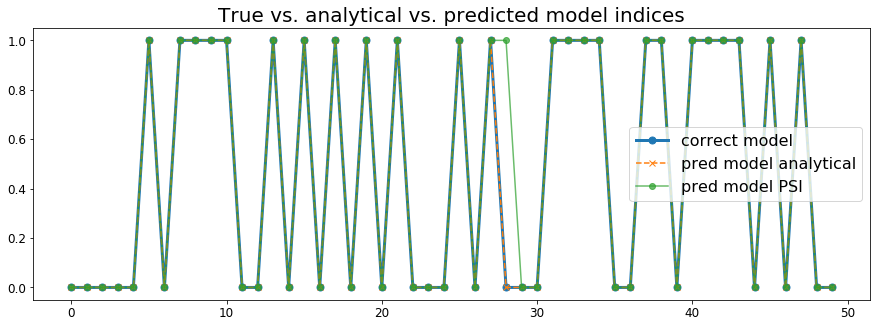

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(mi_true, 'o-', label='correct model', alpha=1., markersize=7, lw=3)
plt.plot(mi_ana, 'x--', label='pred model analytical', alpha=1.)
plt.plot(mi_pred, 'o-', label='pred model PSI', alpha=.7)
plt.title('True vs. analytical vs. predicted model indices')

plt.legend();
#plt.savefig(os.path.join('figures', 'mi_prediciton.png'), dpi=300);